In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [2]:
#the file that contains all issues and all fields
allBounty = pd.read_csv("gitcoin_dataset_5.csv")

#the file that contains fields from 'activities' array e.g. activity_type, duration_create_to_done
activity_coll = pd.read_csv("activities_collection_3.csv")

#the file that contains '# of times bounty increased' from 'activities' array
bounty_changed = pd.read_csv("changedBounty2.csv")

In [3]:
#Cleansing data

activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True) 
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True)
allBounty['funding_organisation'].fillna("NA", inplace = True) 
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)
allBounty['keywords'].fillna("NA", inplace = True)
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True)
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

In [4]:
#merge two dataframe together

outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

In [5]:
#change cathegory to number

#experience_level
outer_merged['experience_level_code'] = outer_merged['experience_level']
find_replace = {"experience_level_code" : {"NA": 0, "Other": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}}
outer_merged.replace(find_replace, inplace=True)

#project_length
outer_merged['project_length_code'] = outer_merged['project_length']
find_replace = {"project_length_code" : {"NA": 0, "Unknown": 0, "Hours": 1, "Days": 24, "Weeks": 168, "Months": 720}} #in hours
outer_merged.replace(find_replace, inplace=True)

In [6]:
#normalization
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler() 
column_names_to_normalize = ['changed_bounty_value','github_comments','increased_bounty_times','description_length','duration_create_to_expire','number_of_activities','number_of_fulfillments','number_of_interests','token_value_in_usdt','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now','duration_create_to_done','duration_create_to_firstAct','duration_create_to_killed','duration_create_to_lastAct','duration_create_to_new_bounty','duration_create_to_start','duration_create_to_stop','duration_create_to_submitted','duration_create_to_worker_applied','number_of_user_in_activities']
x = outer_merged[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
outer_merged_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = outer_merged.index)
outer_merged[column_names_to_normalize] = outer_merged_temp

In [7]:
pd.set_option('display.max_columns', None)
outer_merged_temp.describe()
outer_merged_temp.shape
outer_merged.describe()
outer_merged.shape

,changed_bounty_value,github_comments,increased_bounty_times,description_length,duration_create_to_expire,number_of_activities,number_of_fulfillments,number_of_interests,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities
count,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.000841,0.084412,0.004005,0.051541,0.102374,0.031279,0.010140,0.014849,0.007655,0.000589,5.869119e-04,0.000609,0.000620,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320
std,0.018127,0.117538,0.025336,0.056217,0.274589,0.049440,0.039168,0.040416,0.024649,0.020894,1.702679e-02,0.020923,0.020905,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000045,0.010638,0.000000,0.015718,0.000242,0.012500,0.000000,0.006024,0.000028,0.000010,1.361610e-08,0.000012,0.000010,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765
50%,0.000045,0.042553,0.000000,0.033951,0.000259,0.020000,0.006410,0.006024,0.003430,0.000026,1.270836e-07,0.000029,0.000026,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647
75%,0.000045,0.117021,0.000000,0.068522,0.003145,0.032500,0.006410,0.012048,0.008937,0.000071,1.089288e-05,0.000079,0.000079,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 23)

,description_length,duration_create_to_expire,github_comments,github_issue_number,is_paid,is_success,number_of_activities,number_of_fulfillments,number_of_interests,pk,standard_bounties_id,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,value_true,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities,increased_bounty_times,changed_bounty_value,experience_level_code,project_length_code
count,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.051541,0.102374,0.084412,2.752041e+03,0.580716,0.580716,0.031279,0.010140,0.014849,14940.176483,1.689004e+07,0.007655,0.000589,5.869119e-04,0.000609,0.000620,1.759311e+04,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320,0.004005,0.000841,1.578098,20.155541
std,0.056217,0.274589,0.117538,1.214674e+05,0.493496,0.493496,0.049440,0.039168,0.040416,6748.159187,3.747219e+07,0.024649,0.020894,1.702679e-02,0.020923,0.020905,7.617667e+05,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570,0.025336,0.018127,0.903123,62.679123
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015718,0.000242,0.010638,9.000000e+00,0.000000,0.000000,0.012500,0.000000,0.006024,10345.750000,1.415750e+03,0.000028,0.000010,1.361610e-08,0.000012,0.000010,2.500000e-01,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765,0.000000,0.000045,1.000000,1.000000
50%,0.033951,0.000259,0.042553,7.200000e+01,1.000000,1.000000,0.020000,0.006410,0.006024,14574.500000,2.931500e+03,0.003430,0.000026,1.270836e-07,0.000029,0.000026,3.000000e+00,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647,0.000000,0.000045,2.000000,1.000000
75%,0.068522,0.003145,0.117021,5.212500e+02,1.000000,1.000000,0.032500,0.006410,0.012048,21592.000000,4.158250e+03,0.008937,0.000071,1.089288e-05,0.000079,0.000079,1.500000e+02,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529,0.000000,0.000045,2.000000,24.000000
max,1.000000,1.000000,1.000000,8.223423e+06,1.000000,1.000000,1.000000,1.000000,1.000000,24558.000000,1.000246e+08,1.000000,1.000000,1.000000e+00,1.000000,1.000000,5.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,720.000000


(4584, 87)

In [8]:
#all features used in Table 2 Feature Description
columns_temp = ['pk','is_success','duration_create_to_expire','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now',
                'project_length_code','experience_level_code','project_type',
                'github_comments','number_of_activities','number_of_fulfillments','number_of_interests',
                'description_length','duration_create_to_done','duration_create_to_firstAct','duration_create_to_lastAct',
                'duration_create_to_submitted','duration_create_to_killed','duration_create_to_new_bounty',
                'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                'number_of_user_in_activities','changed_bounty_value','increased_bounty_times','bounty_type','token_name',
                'firstAct_activity_type','lastAct_activity_type']

outer_merged_temp = outer_merged[columns_temp]
outer_merged = outer_merged_temp

In [9]:
outer_merged.describe()
outer_merged.shape

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005
std,6748.159187,0.493496,0.274589,0.020894,1.702679e-02,0.020923,0.020905,62.679123,0.903123,0.117538,0.049440,0.039168,0.040416,0.056217,0.075719,0.029698,0.226041,0.187339,0.086083,0.046084,0.040718,0.061074,0.051110,0.045570,0.018127,0.025336
min,11.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10345.750000,0.000000,0.000242,0.000010,1.361610e-08,0.000012,0.000010,1.000000,1.000000,0.010638,0.012500,0.000000,0.006024,0.015718,0.000000,0.001304,0.023263,0.000000,0.000000,0.355253,0.000000,0.000000,0.000831,0.011765,0.000045,0.000000
50%,14574.500000,1.000000,0.000259,0.000026,1.270836e-07,0.000029,0.000026,1.000000,2.000000,0.042553,0.020000,0.006410,0.006024,0.033951,0.003132,0.001306,0.118539,0.005193,0.000000,0.355684,0.000000,0.000000,0.000835,0.017647,0.000045,0.000000
75%,21592.000000,1.000000,0.003145,0.000071,1.089288e-05,0.000079,0.000079,24.000000,2.000000,0.117021,0.032500,0.006410,0.012048,0.068522,0.031154,0.001310,0.393087,0.030450,0.000000,0.356496,0.000562,0.007055,0.001513,0.023529,0.000045,0.000000
max,24558.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,720.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 31)

In [10]:
#Making categorical variables into numeric representation
feature_to_trans_set1 = ['bounty_type','token_name','project_type','firstAct_activity_type','lastAct_activity_type']

new_raw_data_set1 = pd.get_dummies(outer_merged, columns = feature_to_trans_set1)

In [11]:
#bootstrap sampling

from random import sample

bootstrapped_set1 = new_raw_data_set1.sample(n=4584, replace=True)
bootstrapped_set1.shape

repeats = bootstrapped_set1['pk'].value_counts()
repeats.head()

new_raw_data_set1.describe()
bootstrapped_set1.describe()

(4584, 154)

23938    6
16373    6
3030     5
23917    5
15693    5
Name: pk, dtype: int64

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional,firstAct_activity_type_NA,firstAct_activity_type_bounty_changed,firstAct_activity_type_extend_expiration,firstAct_activity_type_killed_bounty,firstAct_activity_type_new_bounty,firstAct_activity_type_start_work,firstAct_activity_type_unknown_event,firstAct_activity_type_work_done,firstAct_activity_type_work_submitted,firstAct_activity_type_worker_applied,lastAct_activity_type_NA,lastAct_activity_type_bounty_abandonment_escalation_to_mods,lastAct_activity_type_bounty_abandonment_warning,lastAct_activity_type_bounty_changed,lastAct_activity_type_bounty_removed_by_staff,lastAct_activity_type_extend_expiration,lastAct_activity_type_increased_bounty,lastAct_activity_type_killed_bounty,lastAct_activity_type_new_bounty,lastAct_activity_type_new_crowdfund,lastAct_activity_type_new_kudos,lastAct_activity_type_new_tip,lastAct_activity_type_receive_kudos,lastAct_activity_type_receive_tip,lastAct_activity_type_start_work,lastAct_activity_type_stop_work,lastAct_activity_type_unknown_event,lastAct_activity_type_work_done,lastAct_activity_type_work_submitted,lastAct_activity_type_worker_applied,lastAct_activity_type_worker_approved,lastAct_activity_type_worker_rejected
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,458

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional,firstAct_activity_type_NA,firstAct_activity_type_bounty_changed,firstAct_activity_type_extend_expiration,firstAct_activity_type_killed_bounty,firstAct_activity_type_new_bounty,firstAct_activity_type_start_work,firstAct_activity_type_unknown_event,firstAct_activity_type_work_done,firstAct_activity_type_work_submitted,firstAct_activity_type_worker_applied,lastAct_activity_type_NA,lastAct_activity_type_bounty_abandonment_escalation_to_mods,lastAct_activity_type_bounty_abandonment_warning,lastAct_activity_type_bounty_changed,lastAct_activity_type_bounty_removed_by_staff,lastAct_activity_type_extend_expiration,lastAct_activity_type_increased_bounty,lastAct_activity_type_killed_bounty,lastAct_activity_type_new_bounty,lastAct_activity_type_new_crowdfund,lastAct_activity_type_new_kudos,lastAct_activity_type_new_tip,lastAct_activity_type_receive_kudos,lastAct_activity_type_receive_tip,lastAct_activity_type_start_work,lastAct_activity_type_stop_work,lastAct_activity_type_unknown_event,lastAct_activity_type_work_done,lastAct_activity_type_work_submitted,lastAct_activity_type_worker_applied,lastAct_activity_type_worker_approved,lastAct_activity_type_worker_rejected
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.00000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,

RandomForestClassifier(criterion='entropy', max_depth=25)

0.9796511627906976

array([[572,  11],
       [ 17, 776]], dtype=int64)

<Figure size 1152x504 with 0 Axes>

<AxesSubplot:>

Text(0.5, 42.0, 'Predicted label')

Text(123.0, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

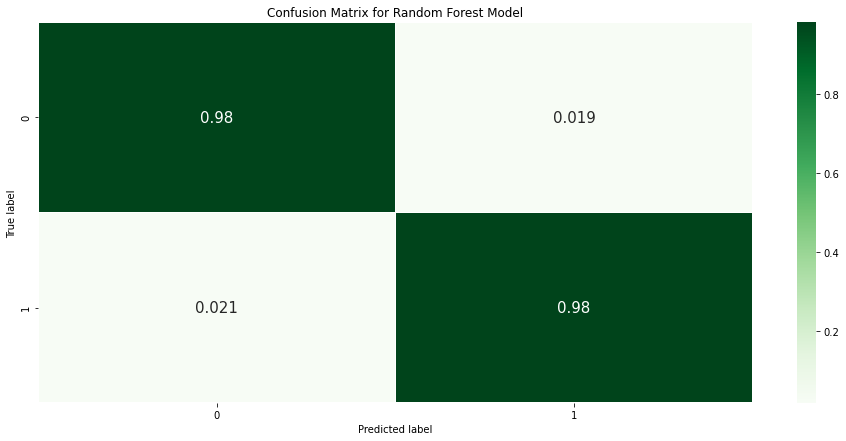

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       583
           1       0.99      0.98      0.98       793

    accuracy                           0.98      1376
   macro avg       0.98      0.98      0.98      1376
weighted avg       0.98      0.98      0.98      1376



array([1.85946346e-02, 1.52550789e-02, 1.02347389e-02, 2.08222788e-02,
       1.54640383e-02, 5.57301438e-03, 6.67383217e-03, 1.37938579e-02,
       4.28116366e-02, 7.94566119e-02, 3.69287746e-02, 1.67403392e-02,
       2.32071148e-01, 2.04034937e-02, 4.35397055e-02, 7.20791402e-02,
       5.25473720e-02, 2.97408010e-02, 1.54764747e-02, 2.23375271e-02,
       1.14609654e-02, 2.33732837e-02, 1.40772747e-03, 1.41565725e-03,
       1.49970392e-03, 1.37721833e-04, 1.95233687e-04, 9.49422558e-04,
       2.93652288e-03, 2.06715500e-03, 3.04741931e-03, 2.35372943e-03,
       6.23042827e-04, 0.00000000e+00, 1.24339503e-04, 1.00979778e-04,
       0.00000000e+00, 5.51550630e-04, 1.45714392e-05, 1.52149993e-05,
       5.72540532e-05, 0.00000000e+00, 1.08202736e-06, 1.15814241e-05,
       5.82238273e-07, 3.56095520e-05, 3.58156352e-06, 1.26938180e-05,
       1.77360652e-05, 0.00000000e+00, 2.89965630e-03, 8.62339852e-05,
       0.00000000e+00, 1.95739526e-04, 5.61262816e-04, 1.82089798e-05,
      

The feature importance for duration_create_to_expire is : 0.018594634590235425
The feature importance for value_in_eth is : 0.015255078907947639
The feature importance for value_in_token is : 0.010234738942082914
The feature importance for value_in_usdt is : 0.020822278810768154
The feature importance for value_in_usdt_now is : 0.015464038332068443
The feature importance for project_length_code is : 0.005573014376695751
The feature importance for experience_level_code is : 0.006673832168993779
The feature importance for github_comments is : 0.013793857894588653
The feature importance for number_of_activities is : 0.042811636586857806
The feature importance for number_of_fulfillments is : 0.07945661194646908
The feature importance for number_of_interests is : 0.036928774595952396
The feature importance for description_length is : 0.016740339187809507
The feature importance for duration_create_to_done is : 0.2320711482283651
The feature importance for duration_create_to_firstAct is : 0.0

,Feature,Feature Importance
12,duration_create_to_done,0.232071
9,number_of_fulfillments,0.079457
15,duration_create_to_submitted,0.072079
16,duration_create_to_killed,0.052547
14,duration_create_to_lastAct,0.043540
8,number_of_activities,0.042812
147,lastAct_activity_type_work_done,0.041609
137,lastAct_activity_type_killed_bounty,0.038883
10,number_of_interests,0.036929
17,duration_create_to_new_bounty,0.029741


In [12]:
#Setting 1

# Split dataset into features and target
y = bootstrapped_set1['is_success']
X = bootstrapped_set1.drop(['is_success','pk'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(bootstrapped_set1.drop(['is_success','pk'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(20)